<a href="https://colab.research.google.com/github/BarbaraMcG/darwin-semantic-change/blob/main/Corpus_processing_8June_pm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracing meaning through time with digital methods: how did Darwin’s language evolve? -- Tuesday 8 June 2021: afternoon session

Barbara McGillivray

##License note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/). The letters have the following license statement: http://creativecommons.org/licenses/by-nc-nd/3.0/ . Many of the texts of the letters are still in copyright to the descendants of the authors. You cannot publish the derivatives of processing these letters nor the letters themselves. The files are shared with you as participants of this course for educational purposes only.

##1. Pre-processing the Darwin corpus

I install version 4.0 of gensim:

In [ ]:
!pip install gensim==4.0

     |████████████████████████████████| 23.9MB 1.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Import libraries

In [ ]:
import os 
from bs4 import BeautifulSoup
from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


I mount the Google drive folder. You should change the path to your Google Drive path:

In [ ]:
drive.mount('/gdrive', force_remount = True) 
%ls '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files' 


Mounted at /gdrive
letters/  Letters_text/  letters.zip  __MACOSX/  Plots/  Plots.png


I unzip the file containing all the letters. 
**This only needs to be done once** and you can skip this cell.


In [ ]:
!unzip '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/letters.zip' -d '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files'

I define the name of the folder containing the unzipped files:

In [ ]:
folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/letters'

I define the list of all files:

In [ ]:
files = os.listdir(folder)

How many files are in the folder?


In [ ]:
len(files)

15349

We only want xml files:

In [ ]:
files = [f for f in files[:] if f.endswith(".xml")]
len(files)

15348

### Extracting the text of the letters

I create the output folder:

In [ ]:
out_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/Letters_text'
if not os.path.exists(out_folder):
  os.makedirs(out_folder)

We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell.**

In [ ]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #  break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action:
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]    
            # the year is the first four characters of the date:
            year = date_sent[:4]   
          except:
            print("No date")

      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year is not "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text is not "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
      else:
        print("missing corr_action")                 
      
outfile.close()

I define a dataframe from the csv file:

In [ ]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

Let's inspect the first 5 lines:

In [ ]:
print(df.head(5))

                File  ...                                      Transcription
0  DCP-LETT-7806.xml  ...  Very many thanks for all that you have done fo...
1   DCP-LETT-686.xml  ...  – – –Museum three—one from Dr. Richardson who ...
2  DCP-LETT-5977.xml  ...  I have been greatly interested by your last wo...
3  DCP-LETT-5963.xml  ...  several y. ago you gave me very valuable infor...
4   DCP-LETT-692.xml  ...  – Monday Morning My dear Fox When I sent off t...

[5 rows x 5 columns]


What are the names of the columns?

In [ ]:
df.columns

Index(['File', 'Year', 'Sender', 'Receiver', 'Transcription'], dtype='object')

All letters sent in 1831:


In [ ]:
df.loc[df['Year'] == 1831]

,File,Year,Sender,Receiver,Transcription
22,DCP-LETT-123.xml,1831,"Darwin, C. R.","Henslow, J. S.",You must have thought it very odd my not havin...
492,DCP-LETT-136.xml,1831,"Owen, F. M. (a)","Darwin, C. R.",I have this evening heard from Caroline that y...
499,DCP-LETT-122.xml,1831,"Darwin, C. R.","Darwin, S. E.",I have just received the parcel: I suppose it ...
569,DCP-LETT-120.xml,1831,"Darwin, C. R.","Fox, W. D.",When you read this you will understand why I h...
1052,DCP-LETT-121.xml,1831,"Darwin, C. R.","Whitley, C. T.",I daresay you will be surprised when you see t...
1055,DCP-LETT-135.xml,1831,"FitzRoy, Robert","Darwin, C. R.",I read the first sentence of your letter—“Befo...
1129,DCP-LETT-119.xml,1831,"Darwin, C. R.","Darwin, S. E.","Again I am going to trouble you. I suspect, if..."
1146,DCP-LETT-131.xml,1831,"Darwin, C. R.","FitzRoy, Robert",I have been hunting in several shops but have ...
1149,DCP-LETT-125.xml,1831,"Whitley, C. T.","Darwin, C. R.","Your letter, which arrived on my return from S..."
1570,DCP-LETT-124.xml,1831,"Coldstream, John","Darwin, C. R.",I was no less surprized than delighted to see ...


Number of letters per year

In [ ]:
df1 = df.groupby(['Year']).count()
df1 = df1['File']
df1

Year
1821     1
1822     9
1823     2
1824     1
1825     9
        ..
1878    18
1879    14
1880    30
1881    12
1882     2
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

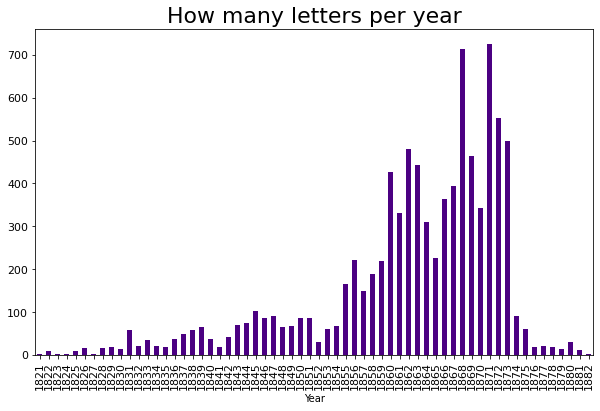

In [ ]:
ax = df1.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

### List of scientific terms

Some letters also have a list of keywords, some of which are tagged as scientific terms. Let's create a separate list for those.

I read the letters and extract the content of the tag `term` inside `keywords`. NB: This step can take a couple of hours. **You can skip this cell.**

In [ ]:
# I initialise the list "scientific_terms" containing all keywords tagged as scientific terms:
scientific_terms = []

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 20:
  #  break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    scientific_term = ""
    
    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract terms, which are direct children of the "keywords" tag:
    try:
      terms = soup.find("keywords").findAll("term", {"type" : "scientific_terms"}, recursive=False)
      #print(str(terms))
      if terms:
        for t in terms:
          #print("t", str(t))
          #extract scientific terms:
          try:
            scientific_term = t.get_text()
            #print("scientific term:", scientific_term)
            scientific_terms.append(scientific_term)
          except:
            print("No scientific term")
    except:
      print("No keywords")


Streaming output truncated to the last 5000 lines.
Reading file number 10607 DCP-LETT-13667.xml
Reading file number 10608 DCP-LETT-12338.xml
Reading file number 10609 DCP-LETT-156.xml
Reading file number 10610 DCP-LETT-5520.xml
Reading file number 10611 DCP-LETT-12836.xml
Reading file number 10612 DCP-LETT-10416.xml
Reading file number 10613 DCP-LETT-9790A.xml
Reading file number 10614 DCP-LETT-8591.xml
Reading file number 10615 DCP-LETT-6743.xml
Reading file number 10616 DCP-LETT-12755.xml
Reading file number 10617 DCP-LETT-2813.xml
Reading file number 10618 DCP-LETT-8315.xml
Reading file number 10619 DCP-LETT-6234.xml
Reading file number 10620 DCP-LETT-9291.xml
Reading file number 10621 DCP-LETT-12236.xml
Reading file number 10622 DCP-LETT-7285.xml
Reading file number 10623 DCP-LETT-1842.xml
Reading file number 10624 DCP-LETT-6372.xml
Reading file number 10625 DCP-LETT-2916.xml
Reading file number 10626 DCP-LETT-13284.xml
Reading file number 10627 DCP-LETT-2924.xml
Reading file numbe

I remove duplicates. **You can skip this cell if you skipped the previous one.**

In [ ]:
scientific_terms = set(scientific_terms)
len(scientific_terms)

I save the list to a file. **You can skip this cell if you skipped the previous ones.**

In [ ]:
# open output file:
st_outfile = open(os.path.join(out_folder, 'scientific_terms.txt'), 'w+')

for t in scientific_terms:
  st_outfile.write(t+"\n")

# close output file:
st_outfile.close()

I select single-word terms and exclude one-character strings. **You can skip this cell if you skipped the previous ones.**

In [ ]:
selected_scientific_terms = []
for t in scientific_terms:
  if " " not in t and len(t) > 1 and t is not "":
    selected_scientific_terms.append(t)
len(selected_scientific_terms)

88

Write to a file. **You can skip this cell if you skipped the previous ones.**

In [ ]:
st_outfile = open(os.path.join(out_folder, 'selected_scientific_terms.txt'), 'w+')

for t in selected_scientific_terms:
  st_outfile.write(t+"\n")

# close output file:
st_outfile.close()

Read file:

In [ ]:
scientific_terms = []
st_file = open(os.path.join(out_folder, 'scientific_terms.txt'), 'r')
for line in st_file:
  term = line.strip()
  print(term)
  scientific_terms.append(term)
st_file.close()

parasites
sex differences
fertilisation and generation
endemic forms
fossils
learning and memory
exclamations
common forms
worldwide distribution
number of species
intermediate forms, gradation
mothers
behaviour
time, ‘inorganic’ (geological, historical)
cultivation
variation
divergence
scientific controversy, confrontation
shells
young, offspring
reflex behaviour
flowers and buds
sea, sea-currents
mineralogy, minerals
physical ‘external’ characters
cirripedes
vivisection
queries / requests
highness and lowness
Journal of Researches
seasons
fathers
imperfection of geological record
f
Thermometer
systematics
homology
freshwater conditions
breeding behaviour
sports
nectar
social behaviour
mongrels
pathology, disease
ice, ice-action, icebergs, glaciers
wide-ranging or mundane forms
indoor conditions
frogs
selection
number, increase and decrease
death
dispersion
introduced forms
parents
mimicry
degeneration
ammonia
transmission, ‘taking after’
ants, slave-making
aboriginal forms
os coccyx


## 2. Training word embeddings

First, I split the letters into sentences:

In [ ]:
df['Transcription_sentences'] = [sent_tokenize(df['Transcription'].iloc[i]) for i in range(df.shape[0])]

Then, I tokenize the sentences:

In [ ]:
df['Tokens'] = [word_tokenize(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_sentences,Tokens
0,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,[Very many thanks for all that you have done f...,"[Very, many, thanks, for, all, that, you, have..."
1,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– – –Museum three—one from Dr. Richardson who ...,[– – –Museum three—one from Dr. Richardson who...,"[–, –, –Museum, three—one, from, Dr., Richards..."
2,DCP-LETT-5977.xml,1868,"Peel, Jonathan","Darwin, C. R.",I have been greatly interested by your last wo...,[I have been greatly interested by your last w...,"[I, have, been, greatly, interested, by, your,..."
3,DCP-LETT-5963.xml,1868,"Darwin, C. R.","Hewitt, Edward",several y. ago you gave me very valuable infor...,[several y. ago you gave me very valuable info...,"[several, y., ago, you, gave, me, very, valuab..."
4,DCP-LETT-692.xml,1843,"Darwin, C. R.","Fox, W. D.",– Monday Morning My dear Fox When I sent off t...,[– Monday Morning My dear Fox When I sent off ...,"[–, Monday, Morning, My, dear, Fox, When, I, s..."
...,...,...,...,...,...,...,...
8902,DCP-LETT-847.xml,1845,"Darwin, C. R.","Hooker, J. D.",Down Bromley Kent March 31st My dear Hooker I ...,[Down Bromley Kent March 31st My dear Hooker I...,"[Down, Bromley, Kent, March, 31st, My, dear, H..."
8903,DCP-LETT-8292.xml,1872,"Darwin, C. R.","Bowman, William",I send by Railway today the book which you len...,[I send by Railway today the book which you le...,"[I, send, by, Railway, today, the, book, which..."
8904,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","[Dr. Hugo de Vries, who has done such excellen...","[Dr., Hugo, de, Vries, ,, who, has, done, such..."
8905,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"[I received your letter today., The larger bro...","[I, received, your, letter, today, ., The, lar..."


I exclude stopwords:

In [ ]:
stopWords = set(stopwords.words('english'))
df["Tokens_nostop"] = ''
for i in range(df.shape[0]):
  df['Tokens_nostop'].iloc[i] = [t for t in df['Tokens'].iloc[i] if t not in stopWords and t not in '''!()-[]{};:'"\,<>./?@#$%^&*_~''']
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,File,Year,Sender,Receiver,Transcription,Transcription_sentences,Tokens,Tokens_nostop
0,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,[Very many thanks for all that you have done f...,"[Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, done, me.—, What, earth, ..."
1,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– – –Museum three—one from Dr. Richardson who ...,[– – –Museum three—one from Dr. Richardson who...,"[–, –, –Museum, three—one, from, Dr., Richards...","[–, –, –Museum, three—one, Dr., Richardson, we..."
2,DCP-LETT-5977.xml,1868,"Peel, Jonathan","Darwin, C. R.",I have been greatly interested by your last wo...,[I have been greatly interested by your last w...,"[I, have, been, greatly, interested, by, your,...","[I, greatly, interested, last, work, “, The, v..."
3,DCP-LETT-5963.xml,1868,"Darwin, C. R.","Hewitt, Edward",several y. ago you gave me very valuable infor...,[several y. ago you gave me very valuable info...,"[several, y., ago, you, gave, me, very, valuab...","[several, y., ago, gave, valuable, information..."
4,DCP-LETT-692.xml,1843,"Darwin, C. R.","Fox, W. D.",– Monday Morning My dear Fox When I sent off t...,[– Monday Morning My dear Fox When I sent off ...,"[–, Monday, Morning, My, dear, Fox, When, I, s...","[–, Monday, Morning, My, dear, Fox, When, I, s..."
...,...,...,...,...,...,...,...,...
8902,DCP-LETT-847.xml,1845,"Darwin, C. R.","Hooker, J. D.",Down Bromley Kent March 31st My dear Hooker I ...,[Down Bromley Kent March 31st My dear Hooker I...,"[Down, Bromley, Kent, March, 31st, My, dear, H...","[Down, Bromley, Kent, March, 31st, My, dear, H..."
8903,DCP-LETT-8292.xml,1872,"Darwin, C. R.","Bowman, William",I send by Railway today the book which you len...,[I send by Railway today the book which you le...,"[I, send, by, Railway, today, the, book, which...","[I, send, Railway, today, book, lent, me.—, I,..."
8904,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","[Dr. Hugo de Vries, who has done such excellen...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, done, excellent, work, ..."
8905,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"[I received your letter today., The larger bro...","[I, received, your, letter, today, ., The, lar...","[I, received, letter, today, The, larger, brow..."


I save the dataframe to a file:

In [ ]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t")

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [ ]:
start = time.time()
cbow_w5_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 25 seconds


Different parameters. **You can skip this cell.**

In [ ]:
start = time.time()
cbow_w5_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0 has taken", round(end - start), "seconds")

cbow_w5_f0 has taken 26 seconds
sg_w5_f1 has taken 90 seconds
sg_w5_f0 has taken 86 seconds
cbow_w10_f1 has taken 29 seconds
cbow_w10_f0 has taken 29 seconds
sg_w10_f1 has taken 166 seconds
sg_w10_f0 has taken 158 seconds


Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [ ]:
models_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Models'
models = [cbow_w5_f1, cbow_w5_f0, sg_w5_f1, sg_w5_f0, cbow_w10_f1, cbow_w10_f0, sg_w10_f1, sg_w10_f0]
models_names = ["cbow_w5_f1", "cbow_w5_f0", "sg_w5_f1", "sg_w5_f0", "cbow_w10_f1", "cbow_w10_f0", "sg_w10_f1", "sg_w10_f0"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2
Saving model number 3
Saving model number 4
Saving model number 5
Saving model number 6
Saving model number 7
Saving model number 8


Load the models:

In [ ]:
models_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Models'
cbow_w5_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1"))
cbow_w5_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0"))
sg_w5_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1"))
sg_w5_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0"))
cbow_w10_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1"))
cbow_w10_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0"))
sg_w10_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1"))
sg_w10_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0"))
models = [cbow_w5_f1, cbow_w5_f0, sg_w5_f1, sg_w5_f0, cbow_w10_f1, cbow_w10_f0, sg_w10_f1, sg_w10_f0]
models_names = ["cbow_w5_f1", "cbow_w5_f0", "sg_w5_f1", "sg_w5_f0", "cbow_w10_f1", "cbow_w10_f0", "sg_w10_f1", "sg_w10_f0"]

Let's get the embedding for the word "letter"

In [ ]:
sg_w10_f0.wv['letter']

array([ 1.40385386e-02,  5.09701669e-01,  7.44570866e-02, -1.31749243e-01,
        2.43444338e-01, -1.45412497e-02,  5.29104173e-02,  8.20541441e-01,
       -2.84786541e-02, -1.30726453e-02,  1.19011492e-01,  2.51678288e-01,
        3.75087559e-01, -2.71651983e-01, -2.72559524e-01, -3.97555858e-01,
        4.34914410e-01,  2.60752179e-02, -2.22564340e-01, -1.84155554e-01,
        2.86100954e-01, -5.40993989e-01, -2.43196905e-01,  1.03017308e-01,
        3.66650164e-01, -3.26548189e-01,  1.55564353e-01,  6.20228909e-02,
       -1.39738634e-01,  3.66126858e-02,  9.09242854e-02, -1.03495277e-01,
        1.88130453e-01, -9.74130109e-02, -2.29625687e-01,  1.02380477e-01,
        1.60461232e-01, -4.00171399e-01, -1.50810078e-01,  2.40569025e-01,
       -2.17895150e-01, -1.18446782e-01,  2.05252711e-02, -9.22695622e-02,
        2.00705469e-01,  1.65418386e-01,  1.36066779e-01,  1.56191234e-02,
       -2.19024688e-01,  1.14047661e-01,  3.77790183e-01,  4.20202047e-01,
       -1.96687743e-01,  

In [ ]:
for i in range(len(models)):
  print("Similarity between letter and write in", models_names[i], models[i].wv.similarity('letter', 'write'))
  print("Similarity between letter and say in", models_names[i], models[i].wv.similarity('letter', 'say'))
  print("Similarity between letter and odd in", models_names[i], models[i].wv.similarity('letter', 'odd'))
  if models[i].wv.similarity('letter', 'write') > models[i].wv.similarity('letter', 'say') and models[i].wv.similarity('letter', 'say') > models[i].wv.similarity('letter', 'odd'):
    print("yes")

Similarity between letter and write in cbow_w5_f1 0.5323351
Similarity between letter and say in cbow_w5_f1 0.43509564
Similarity between letter and odd in cbow_w5_f1 0.14743409
yes
Similarity between letter and write in cbow_w5_f0 0.53237575
Similarity between letter and say in cbow_w5_f0 0.43065682
Similarity between letter and odd in cbow_w5_f0 0.15893325
yes
Similarity between letter and write in sg_w5_f1 0.544064
Similarity between letter and say in sg_w5_f1 0.3789434
Similarity between letter and odd in sg_w5_f1 0.37376046
yes
Similarity between letter and write in sg_w5_f0 0.53821564
Similarity between letter and say in sg_w5_f0 0.4017873
Similarity between letter and odd in sg_w5_f0 0.372716
yes
Similarity between letter and write in cbow_w10_f1 0.54446816
Similarity between letter and say in cbow_w10_f1 0.4586619
Similarity between letter and odd in cbow_w10_f1 0.15409233
yes
Similarity between letter and write in cbow_w10_f0 0.57367694
Similarity between letter and say in cbo

In all models the similarity between *letter* and *write* is higher than the similarity between *letter* and *say*, which is higher than the similarity between *letter* and *odd*, which is good news. 

Let's look at the most similar words (i.e.) neighbours of *letter*:

In [ ]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

cbow_w5_f1 [('note', 0.9618892073631287), ('letter.—', 0.8661161661148071), ('letters', 0.8490368127822876), ('note.—', 0.77968430519104), ('communication', 0.7586898803710938), ('number.—I', 0.7363070845603943), ('it—it', 0.7291051149368286), ('reply', 0.7170781493186951), ('farewell—I', 0.7055273056030273), ('safe', 0.7027645111083984)]
cbow_w5_f0 [('note', 0.9590798616409302), ('letter.—', 0.8679436445236206), ('letters', 0.8432912230491638), ('Mytton', 0.7913126349449158), ('note.—', 0.7743099331855774), ('communication', 0.7553965449333191), ('reply', 0.7222354412078857), ('Pomona', 0.7188097834587097), ('letter—', 0.7177392244338989), ('23d.—', 0.7077696323394775)]
sg_w5_f1 [('note', 0.8198344111442566), ('letter.—', 0.809354305267334), ('Letter', 0.7743858695030212), ('letters', 0.7704879641532898), ('letter—', 0.7553732395172119), ('note.—', 0.7457441687583923), ('message', 0.7304669618606567), ('communication', 0.7303237318992615), ('inst', 0.7149249911308289), ('communication

In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. For the purposes of this exercise, I will choose the richest model, sg_w10_f0.

In [ ]:
model = sg_w10_f0

Extract the vocabulary; model.wv.vocab is a dictionary of {word: object of numeric vector}

In [ ]:
X = dict()
vocab = list()
for index, word in enumerate(model.wv.index_to_key):
  print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  vocab.append(word)
  X[word] = model.wv[word]

Streaming output truncated to the last 5000 lines.
word #84899/89899 is Rostellaria
word #84900/89899 is Improvisus
word #84901/89899 is rebuf
word #84902/89899 is Spongicola
word #84903/89899 is od
word #84904/89899 is Dalhousianum
word #84905/89899 is Risso
word #84906/89899 is visid
word #84907/89899 is calcareo-crustaceous
word #84908/89899 is Saxifrages.—
word #84909/89899 is THH
word #84910/89899 is fulvipes
word #84911/89899 is abstract—
word #84912/89899 is picescentibus
word #84913/89899 is Kol
word #84914/89899 is 1845—
word #84915/89899 is Petrop
word #84916/89899 is Beikos
word #84917/89899 is Fascic
word #84918/89899 is Entomologica
word #84919/89899 is Meletemata
word #84920/89899 is Kolenati
word #84921/89899 is Wingless
word #84922/89899 is doctrinæ
word #84923/89899 is Darwinianæ
word #84924/89899 is Henrico
word #84925/89899 is Domino
word #84926/89899 is cel
word #84927/89899 is eximium
word #84928/89899 is hocce
word #84929/89899 is Dedicamus
word #84930/89899 is La

In [ ]:
X = model.wv[vocab]
vocab[:5]

['I', '|', 'one', 'much', '’']

## 3. Visualising the word embeddings

To visualise the semantic space I need to reduce it to two dimensions, I will use [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis):

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

Quality of the PCA:

In [ ]:
pca.explained_variance_ratio_

array([0.25568465, 0.1381528 ])

The first two components account for about 36% of the explained variance.

First attempt at visualisation:

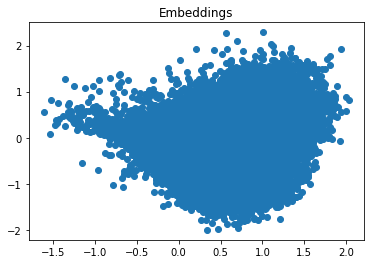

In [ ]:
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Embeddings')
plt.show()

I select the words with frequency higher than 200:

In [ ]:
print(str(len(vocab)))
selected_words = []
for item in vocab:
   #if model.wv.vocab[item].count > 200:
   if model.wv.get_vecattr(item, "count") > 200:
     selected_words.append(item)
print(str(len(selected_words)))
selected_words[:5]

89899
1219


['I', '|', 'one', 'much', '’']

Annotated the plot with the words:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0.0, flags=flags)


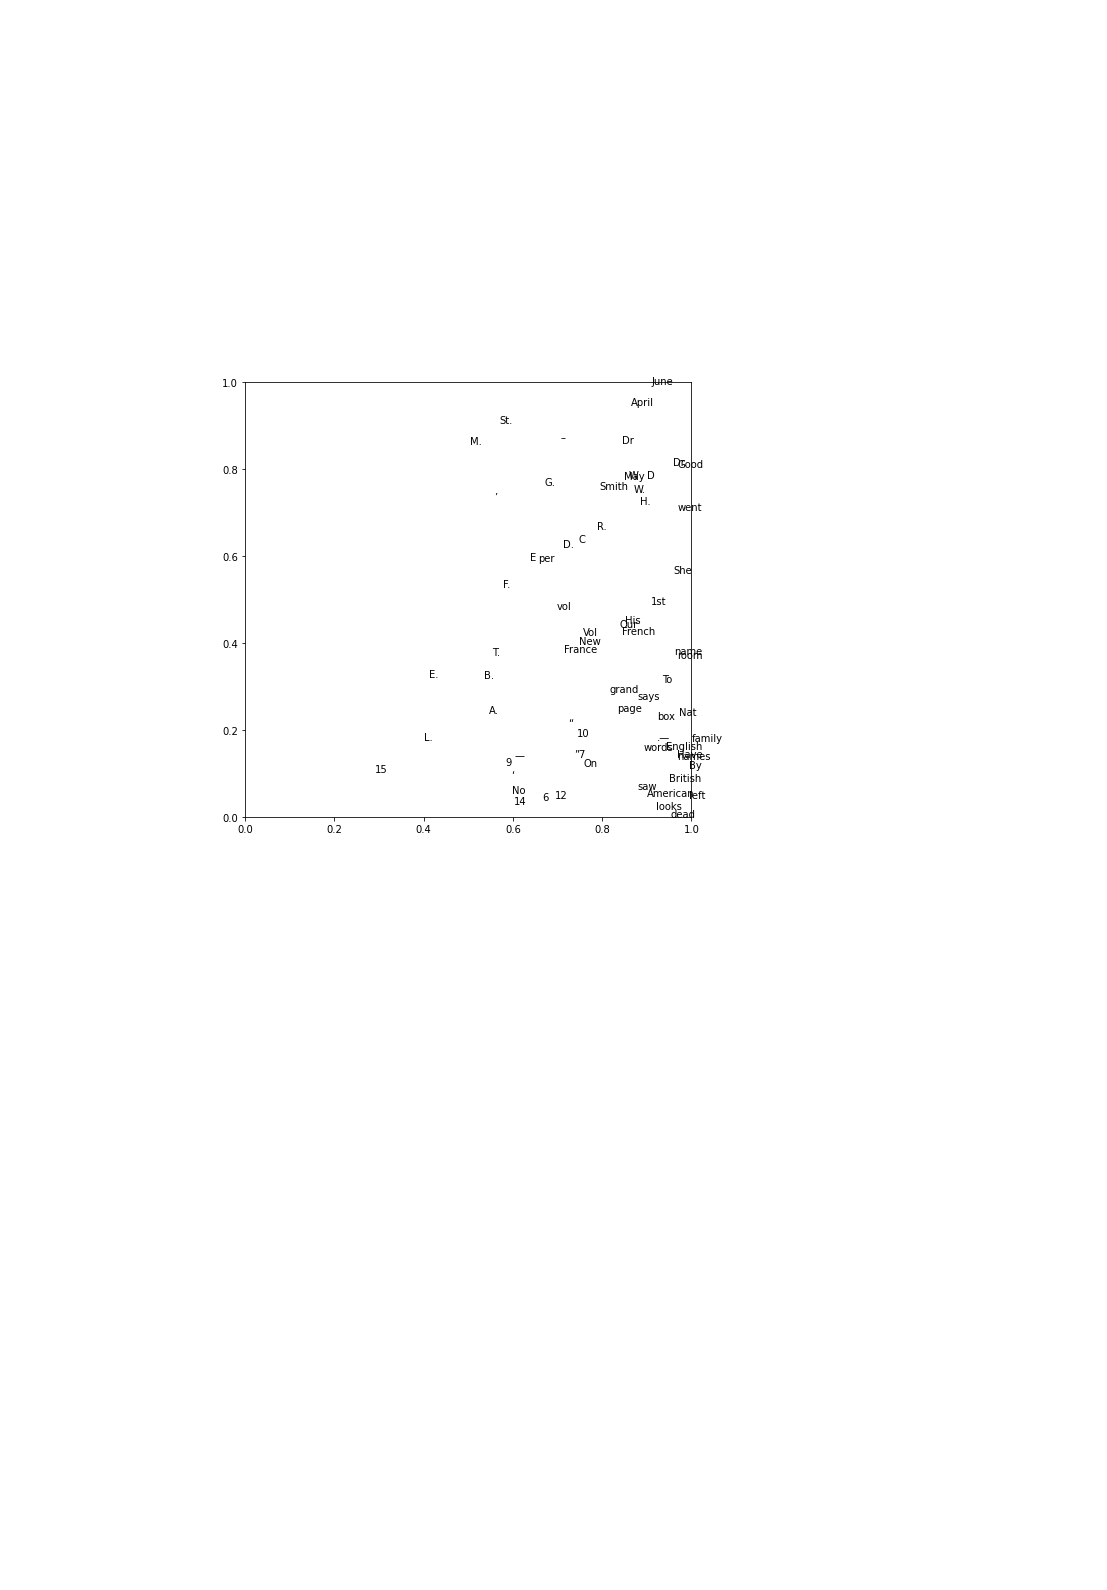

In [ ]:
plt.figure(figsize=(8,8))
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Embeddings of words with freq > 200')
for i, word in enumerate(selected_words):
  plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

For a better visualisation, I first apply PCA

In [ ]:
pca50 = PCA(n_components=50)
result50 = pca50.fit_transform(X)

Then t-sne. **This can take several minutes. You can skip this cell.**

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(result50)
np.save(os.path.join(models_folder, 'tsne.npy'), tsne_results) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 89899 samples in 1.220s...
[t-SNE] Computed neighbors for 89899 samples in 877.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 89899
[t-SNE] Computed conditional probabilities for sample 2000 / 89899
[t-SNE] Computed conditional probabilities for sample 3000 / 89899
[t-SNE] Computed conditional probabilities for sample 4000 / 89899
[t-SNE] Computed conditional probabilities for sample 5000 / 89899
[t-SNE] Computed conditional probabilities for sample 6000 / 89899
[t-SNE] Computed conditional probabilities for sample 7000 / 89899
[t-SNE] Computed conditional probabilities for sample 8000 / 89899
[t-SNE] Computed conditional probabilities for sample 9000 / 89899
[t-SNE] Computed conditional probabilities for sample 10000 / 89899
[t-SNE] Computed conditional probabilities for sample 11000 / 89899
[t-SNE] Computed conditional probabilities for sample 12000 / 89899
[t-SNE] Computed conditional probabilities for 

Load t-sne model:

In [ ]:
tsne_results = np.load(os.path.join(models_folder, 'tsne.npy'))

Visualise:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0, flags=flags)


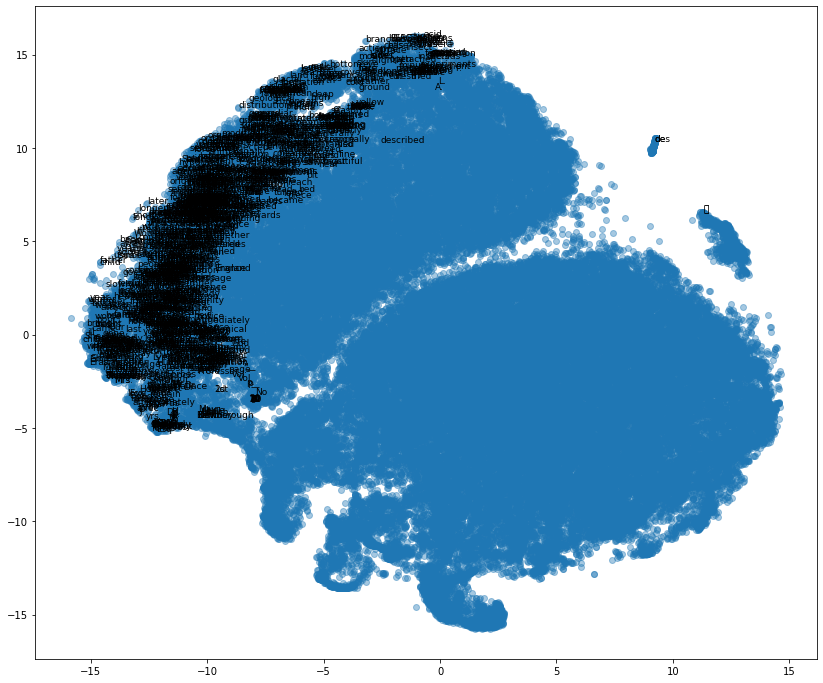

In [ ]:
plots_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/Plots'
if not os.path.exists(plots_folder):
  os.makedirs(plots_folder)

plt.figure(figsize=(14,12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.4)
for i, token in enumerate(selected_words):
  plt.annotate(token, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=9)
#plt.show()
# save figure to file:
plt.savefig(os.path.join(plots_folder, "Selected_words.png"))

I now display only the  scientific terms:

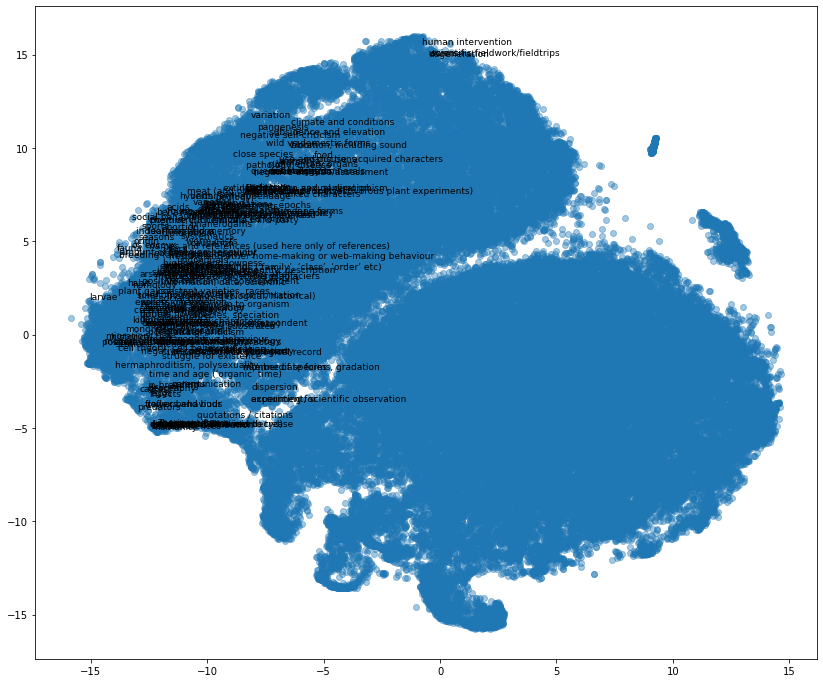

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.4)
for i, token in enumerate(scientific_terms):
  plt.annotate(token, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=9)
#plt.show()
plt.savefig(os.path.join(plots_folder, "Scientific_terms.png"))